In [1]:
import networkx as nx
import torch
from torch_geometric.utils import from_networkx
import torch_geometric.transforms as T
import random
import numpy as np
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch import Tensor
import torch.nn.functional as F
from torch_geometric.loader import LinkNeighborLoader
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

In [2]:
G = nx.read_gml("/home/schoenstein/these/gnn_postbiblio/graph/graph_light.gml")
data = from_networkx(G)
#data.x = torch.ones((data.num_nodes, 1)) # aucun attributs alors on donne la même valeur à tous les noeuds
#data.x = torch.stack([data.degree, data.clustering], dim = -1) # on fusionne les attributs danx x
#del data["degree"]
#del data["clustering"]
print(data)

Data(edge_index=[2, 830562], num_nodes=116979)


In [3]:
train = "double split"

if train == "random":
    transform = T.RandomLinkSplit(
        num_val = 0.1,  
        num_test = 0.1,  
        disjoint_train_ratio = 0,  
        neg_sampling_ratio = 1,
        is_undirected = True
    )
    train_data, val_data, test_data = transform(data)
    print(train_data)
    print(val_data)
    print(test_data)

elif train == "controlled":
    components = list(nx.connected_components(G))
    cc_mapping = {}
    for i, cc in enumerate(components):
        for node in cc:
            cc_mapping[node] = i
    
    def negative_sampling(set_ratio, neg_ratio, inside_ratio):
        neg_edges = []
        inside_edges = 0
        inside_max = len(list(G.edges())) * neg_ratio * set_ratio * inside_ratio
        nodes = list(cc_mapping.keys())
        while len(neg_edges) < len(list(G.edges())) * neg_ratio * set_ratio:
            i = random.choice(nodes)
            j = random.choice(nodes)
            if i != j:
                if not G.has_edge(i,j):
                    if cc_mapping[i] == cc_mapping[j]:
                        neg_edges.append([i,j])
                    elif inside_edges < inside_max:
                        neg_edges.append([i,j])
                        inside_edges = inside_edges + 1
            print(len(neg_edges))
        return neg_edges
    
    random_edges = list(G.edges())
    random.shuffle(random_edges)
    train_val_test_ratio = [0.8, 0.1, 0.1]
    n = len(random_edges)
    n_train = int(n * train_val_test_ratio[0])
    n_val = int(n * train_val_test_ratio[1])
    n_test = n - n_train - n_val
    train_pos = random_edges[:n_train]
    val_pos   = random_edges[n_train:n_train+n_val]
    test_pos  = random_edges[n_train+n_val:]

    train_neg = negative_sampling(train_val_test_ratio[0], 2, 0.5)
    val_neg = negative_sampling(train_val_test_ratio[1], 1, 0.5)
    test_neg = negative_sampling(train_val_test_ratio[2], 1, 0.5)

    def to_edge_index(edge_list):
        return torch.tensor(edge_list, dtype = torch.long).t()
    
    train_pos = to_edge_index(train_pos)
    val_pos = to_edge_index(val_pos)
    test_pos = to_edge_index(test_pos)
    train_neg = to_edge_index(train_neg)
    val_neg = to_edge_index(val_neg)
    test_neg = to_edge_index(test_neg)

    print(train_pos, val_pos, test_pos, train_neg, val_neg, test_neg)

elif train == "double split":
    cc = list(nx.connected_components(G))
    neg_inside = 0
    train_list = []
    val_list = []
    test_list = []
    for c in cc:
        G2 = G.subgraph(c).copy()
        data2 = from_networkx(G2)
        transform = T.RandomLinkSplit(
                num_val = 0.1,  
                num_test = 0.1,  
                disjoint_train_ratio = 0,  
                neg_sampling_ratio = 1.5,
                is_undirected = True
            )
        train_data2, val_data2, test_data2 = transform(data2)
        neg_inside = neg_inside + len(train_data2.edge_label)
        train_list.append(train_data2)
        val_list.append(val_data2)
        test_list.append(test_data2)
    ratio_neg_inside = neg_inside/(len(list(G.edges()))*2)
    print(ratio_neg_inside)
    transform = T.RandomLinkSplit(
            num_val = 0.1,  
            num_test = 0.1,  
            disjoint_train_ratio = 0,  
            neg_sampling_ratio = 1 - ratio_neg_inside,
            is_undirected = True
        )
    train_data3, val_data3, test_data3 = transform(data)

    #pos_train = torch.cat([d.edge_label_index[:, d.edge_label==1] 
                             #for d in train_list], dim=1)
    pos_train = train_data3.edge_label_index[:, train_data3.edge_label == 1]
    #pos_val = torch.cat([d.edge_label_index[:, d.edge_label==1] 
                           #for d in val_list], dim=1)
    pos_val = val_data3.edge_label_index[:, val_data3.edge_label == 1]
    #pos_test = torch.cat([d.edge_label_index[:, d.edge_label==1] 
                            #for d in test_list], dim=1)
    pos_test = test_data3.edge_label_index[:, test_data3.edge_label == 1]
    neg_train1 = torch.cat([d.edge_label_index[:, d.edge_label==0] 
                             for d in train_list], dim=1)
    neg_val1 = torch.cat([d.edge_label_index[:, d.edge_label==0] 
                           for d in val_list], dim=1)
    neg_test1 = torch.cat([d.edge_label_index[:, d.edge_label==0] 
                            for d in test_list], dim=1)
    neg_train2 = train_data3.edge_label_index[:, train_data3.edge_label==0]             
    neg_val2 = val_data3.edge_label_index[:, val_data3.edge_label==0] 
    neg_test2 = test_data3.edge_label_index[:, test_data3.edge_label==0]
    neg_train = torch.cat([neg_train1, neg_train2], dim=1)
    neg_val = torch.cat([neg_val1, neg_val2], dim=1)
    neg_test = torch.cat([neg_test1, neg_test2], dim=1)
    train_data = Data(
        edge_index=train_data3.edge_index,
        num_nodes=data.num_nodes,
        edge_label_index=torch.cat([pos_train, neg_train], dim=1),
        edge_label=torch.cat([
            torch.ones(pos_train.size(1), dtype=torch.long),
            torch.zeros(neg_train.size(1), dtype=torch.long)
        ])
    )
    val_data = Data(
        edge_index=val_data3.edge_index,
        num_nodes=data.num_nodes,
        edge_label_index=torch.cat([pos_val, neg_val], dim=1),
        edge_label=torch.cat([
            torch.ones(pos_val.size(1), dtype=torch.long),
            torch.zeros(neg_val.size(1), dtype=torch.long)
        ])
    )
    test_data = Data(
        edge_index=test_data3.edge_index,
        num_nodes=data.num_nodes,
        edge_label_index=torch.cat([pos_test, neg_test], dim=1),
        edge_label=torch.cat([
            torch.ones(pos_test.size(1), dtype=torch.long),
            torch.zeros(neg_test.size(1), dtype=torch.long)
        ])
    )
    train_data.x = torch.ones((train_data.num_nodes, 1))
    val_data.x = torch.ones((val_data.num_nodes, 1))
    test_data.x = torch.ones((test_data.num_nodes, 1))
    print(train_data)
    print(val_data)
    print(test_data)

/home/schoenstein/.conda/envs/graphe/lib/python3.9/site-packages/torch_geometric/transforms/random_link_split.py:245: UserWarning: There are not enough negative edges to satisfy the provided sampling ratio. The ratio will be adjusted to 0.00.
  warnings.warn(
/home/schoenstein/.conda/envs/graphe/lib/python3.9/site-packages/torch_geometric/transforms/random_link_split.py:245: UserWarning: There are not enough negative edges to satisfy the provided sampling ratio. The ratio will be adjusted to 0.62.
  warnings.warn(
/home/schoenstein/.conda/envs/graphe/lib/python3.9/site-packages/torch_geometric/transforms/random_link_split.py:245: UserWarning: There are not enough negative edges to satisfy the provided sampling ratio. The ratio will be adjusted to 0.33.
  warnings.warn(
/home/schoenstein/.conda/envs/graphe/lib/python3.9/site-packages/torch_geometric/transforms/random_link_split.py:245: UserWarning: There are not enough negative edges to satisfy the provided sampling ratio. The ratio wil

0.8155513977282852
Data(edge_index=[2, 664450], num_nodes=116979, edge_label_index=[2, 728450], edge_label=[728450], x=[116979, 1])
Data(edge_index=[2, 664450], num_nodes=116979, edge_label_index=[2, 85195], edge_label=[85195], x=[116979, 1])
Data(edge_index=[2, 747506], num_nodes=116979, edge_label_index=[2, 90282], edge_label=[90282], x=[116979, 1])


In [4]:
print(train_data)
print(val_data)
print(test_data)

Data(edge_index=[2, 664450], num_nodes=116979, edge_label_index=[2, 728450], edge_label=[728450])
Data(edge_index=[2, 664450], num_nodes=116979, edge_label_index=[2, 85195], edge_label=[85195])
Data(edge_index=[2, 747506], num_nodes=116979, edge_label_index=[2, 90282], edge_label=[90282])


In [5]:
"""transform = T.RandomLinkSplit(
        num_val = 0.1,  
        num_test = 0.1,  
        disjoint_train_ratio = 0,  
        neg_sampling_ratio = 1,
        is_undirected = True
    )
train_data, val_data, test_data = transform(data)
print(train_data)
print(val_data)
print(test_data)
"""
G_train = nx.Graph()
G_train.add_nodes_from(range(train_data.num_nodes))
G_train.add_edges_from(train_data.edge_index.t().tolist())
print(G_train)

degree = dict(G_train.degree())
max_degree = max(degree.values())
degree_norm = {n: d/max_degree for n, d in degree.items()}
print(len(degree))
print(max_degree)
print(len(degree_norm))
clustering = nx.clustering(G_train)
print(len(clustering))

degree_tensor = torch.tensor(list(degree_norm.values()), dtype=torch.float32)
clustering_tensor = torch.tensor(list(clustering.values()), dtype=torch.float32)
print(degree_tensor)
print(clustering_tensor)

train_data.x = torch.stack([degree_tensor, clustering_tensor], dim=-1)
val_data.x = train_data.x.clone()
test_data.x = train_data.x.clone()

print(train_data)
print(val_data)
print(test_data)

Graph with 116979 nodes and 332225 edges
116979
689
116979
116979
tensor([0.0058, 0.0058, 0.0044,  ..., 0.0334, 0.0290, 0.0029])
tensor([1.0000, 0.6667, 1.0000,  ..., 0.0000, 0.0000, 0.0000])
Data(edge_index=[2, 664450], num_nodes=116979, edge_label_index=[2, 728450], edge_label=[728450], x=[116979, 2])
Data(edge_index=[2, 664450], num_nodes=116979, edge_label_index=[2, 85195], edge_label=[85195], x=[116979, 2])
Data(edge_index=[2, 747506], num_nodes=116979, edge_label_index=[2, 90282], edge_label=[90282], x=[116979, 2])


In [4]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr = "lstm") #tester aggr : mean, max, lstm
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr = "lstm")

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x


class Predictor(torch.nn.Module):
    def forward(self, x, edge_label_index):
        edge_emb_src = x[edge_label_index[0]]
        edge_emb_dst = x[edge_label_index[1]]
        edge_emb_src = F.normalize(edge_emb_src, dim = -1) #tester sans la normalisation
        edge_emb_dst = F.normalize(edge_emb_dst, dim = -1)
        pred = (edge_emb_src * edge_emb_dst).sum(dim = -1)
        return pred
    

class Model(torch.nn.Module):
    def __init__(self, in_channels, hiden_channels):
        super().__init__()
        self.gnn = GNN(in_channels, hiden_channels)
        self.predictor = Predictor()
    
    def forward(self, data):
        x = self.gnn(data.x, data.edge_index)
        pred = self.predictor(x, data.edge_label_index)
        return pred
    

model = Model(in_channels = train_data.x.shape[1], hiden_channels = 64)

In [5]:
train_loader = LinkNeighborLoader(
    data = train_data,
    num_neighbors = [25, 10],
    edge_label_index = train_data.edge_label_index,
    edge_label = train_data.edge_label,
    batch_size = 128,
    shuffle = True
)
val_loader = LinkNeighborLoader(
    data = val_data,
    num_neighbors = [25, 10], 
    edge_label_index = val_data.edge_label_index,
    edge_label = val_data.edge_label,
    batch_size = 128,
    shuffle = True
)

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #testet plusieurs valeurs de lr
#optimizer = torch.optim.Adam(list(model.parameters()) + list(predictor.parameters()), lr=0.01) #si un MLP est utilisé pour la prédiction


def train_epoch():
    model.train()
    total_loss = 0
    count = 0
    for batch in train_loader:
        optimizer.zero_grad()
        pred = model(batch)
        loss = F.binary_cross_entropy_with_logits(pred, batch.edge_label.float())
        loss.backward()
        optimizer.step()
        total_loss = total_loss + loss.item()
        count = count + 1
    return total_loss / count


def evaluate():
    model.eval()
    y_truth = []
    y_pred = []
    for batch in val_loader:
        pred = model(batch)
        y_truth.append(batch.edge_label)
        y_pred.append(torch.sigmoid(pred))
    y_truth = torch.cat(y_truth).numpy()
    y_pred = torch.cat(y_pred).detach().numpy()
    auc = roc_auc_score(y_truth, y_pred)
    ap = average_precision_score(y_truth, y_pred)
    return auc, ap
    
#ROC-AUC : la probabilité qu’un positif ait un score plus haut qu’un négatif
#AP : aproxime l'air sous la courbe Precisoion/Recall, plus les positifs sont rares plus un bon score AP est difficile à obtenir

In [7]:
best_val_auc = 0
limit = 6
count = 0
train_losses = []
val_aps = []
val_aucs = []
for epoch in range(1, 50):
    loss = train_epoch()
    train_losses.append(loss)
    val_auc, val_ap = evaluate()
    val_aps.append(val_ap)
    val_aucs.append(val_auc)
    print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}")
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        count = 0
    else:
        count =  count + 1
        if count >= limit:
            print("Early stop")
            break

Epoch 001, Loss: 0.8573, Val AUC: 0.5723, Val AP: 0.5566
Epoch 002, Loss: 0.8572, Val AUC: 0.4673, Val AP: 0.4717
Epoch 003, Loss: 0.8572, Val AUC: 0.4707, Val AP: 0.4733
Epoch 004, Loss: 0.8572, Val AUC: 0.4919, Val AP: 0.4834
Epoch 005, Loss: 0.8573, Val AUC: 0.4619, Val AP: 0.4688
Epoch 006, Loss: 0.8573, Val AUC: 0.4977, Val AP: 0.4863


KeyboardInterrupt: 

In [ ]:
def plot_metrics(train_losses, val_aps, val_aucs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.ylim((0.5, 0.8))
    plt.title("Training Loss")

    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_aps)
    plt.xlabel("Epoch")
    plt.ylabel("AP (Validation)")
    plt.ylim((0.5, 0.9))
    plt.title("Validation AP")

    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_aucs)
    plt.xlabel("Epoch")
    plt.ylabel("AUC (Validation)")
    plt.ylim((0.5, 0.9))
    plt.title("Validation AUC")

    plt.tight_layout()
    plt.show()

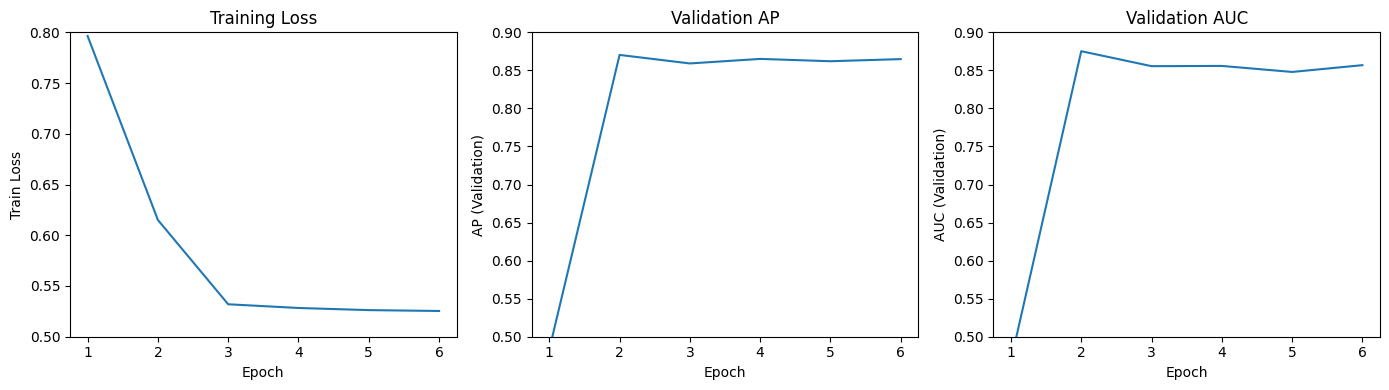

In [ ]:
plot_metrics(train_losses, val_aps, val_aucs)